# Import Libraries

In [91]:
# Basic Libraries
import pandas as pd
import numpy as np
import os
import time
import logging
import datetime
import warnings
import sys
import joblib
from typing import List, Dict, Tuple, Optional
warnings.filterwarnings('ignore')

#  Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='notebook'

from collections import Counter
from sklearn.impute import KNNImputer

# Imbalance libraries
from imblearn.over_sampling import SMOTE

# Model selection and metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, ParameterGrid


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)

#  Modeling Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator
import xgboost

import shap

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.insert(0, root_dir)

from config import *
from preprocessing import preprocess

# Show all columns
pd.set_option('display.max_columns', None)


logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create a handler to print logs in the notebook
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

np.random.seed(42)
shap.initjs()

In [2]:
raw_df = pd.read_csv(RAW_DATA_PATH)
print(f"Shape of data: {raw_df.shape}")

Shape of data: (12316, 32)


In [3]:
# Inspect head
raw_df.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level   
0  17:02:00      Monday              18-30          Male   Above high school  \
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle   
0                Employee              1-2yr           Automobile  \
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle Defect_of_vehicle   
0            Owner              Above 10yr         No defect  \
1            Owner                 5-10yrs         No defect   
2            Owner                     NaN         No defect   
3     Governmental                     NaN         No defect   
4            Owner                 5-10yrs         No defect   

  Area_accident_occured   Lanes_or_Medians   
0     Residential areas                NaN  \
1          Office areas  Undivided Two way   
2    Recreational areas              other   
3          Office areas              other   
4      Industrial areas              other   

                                 Road_allignment Types_of_Junction   
0                 Tangent road with flat terrain       No junction  \
1                 Tangent road with flat terrain       No junction   
2                                            NaN       No junction   
3  Tangent road with mild grade and flat terrain           Y Shape   
4                 Tangent road with flat terrain           Y Shape   

  Road_surface_type Road_surface_conditions       Light_conditions   
0     Asphalt roads                     Dry               Daylight  \
1     Asphalt roads                     Dry               Daylight   
2     Asphalt roads                     Dry               Daylight   
3       Earth roads                     Dry  Darkness - lights lit   
4     Asphalt roads                     Dry  Darkness - lights lit   

  Weather_conditions                        Type_of_collision   
0             Normal  Collision with roadside-parked vehicles  \
1             Normal           Vehicle with vehicle collision   
2             Normal          Collision with roadside objects   
3             Normal           Vehicle with vehicle collision   
4             Normal           Vehicle with vehicle collision   

   Number_of_vehicles_involved  Number_of_casualties Vehicle_movement   
0                            2                     2   Going straight  \
1                            2                     2   Going straight   
2                            2                     2   Going straight   
3                            2                     2   Going straight   
4                            2                     2   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity   
0               na              na                   na                na  \
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement   
0               NaN                  NaN    Not a Pedestrian  \
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestri

In [4]:
# Inspect tail
raw_df.tail()

Time Day_of_week Age_band_of_driver Sex_of_driver   
12311  16:15:00   Wednesday              31-50          Male  \
12312  18:00:00      Sunday            Unknown          Male   
12313  13:55:00      Sunday            Over 51          Male   
12314  13:55:00      Sunday              18-30        Female   
12315  13:55:00      Sunday              18-30          Male   

        Educational_level Vehicle_driver_relation Driving_experience   
12311                 NaN                Employee              2-5yr  \
12312   Elementary school                Employee             5-10yr   
12313  Junior high school                Employee             5-10yr   
12314  Junior high school                Employee         Above 10yr   
12315  Junior high school                Employee             5-10yr   

       Type_of_vehicle Owner_of_vehicle Service_year_of_vehicle   
12311   Lorry (11?40Q)            Owner                     NaN  \
12312       Automobile            Owner                     NaN   
12313            Bajaj            Owner                  2-5yrs   
12314  Lorry (41?100Q)            Owner                  2-5yrs   
12315            Other            Owner                  2-5yrs   

      Defect_of_vehicle Area_accident_occured   
12311         No defect   Outside rural areas  \
12312         No defect   Outside rural areas   
12313         No defect   Outside rural areas   
12314         No defect          Office areas   
12315         No defect   Outside rural areas   

                                       Lanes_or_Medians   
12311                                 Undivided Two way  \
12312  Two-way (divided with broken lines road marking)   
12313  Two-way (divided with broken lines road marking)   
12314                                 Undivided Two way   
12315                                 Undivided Two way   

                                 Road_allignment Types_of_Junction   
12311             Tangent road with flat terrain       No junction  \
12312                                Escarpments       No junction   
12313  Tangent road with mountainous terrain and       No junction   
12314  Tangent road with mountainous terrain and       No junction   
12315  Tangent road with mountainous terrain and           O Shape   

      Road_surface_type Road_surface_conditions       Light_conditions   
12311     Asphalt roads                     Dry               Daylight  \
12312     Asphalt roads                     Dry               Daylight   
12313     Asphalt roads                     Dry               Daylight   
12314     Asphalt roads                     Dry  Darkness - lights lit   
12315     Asphalt roads                     Dry  Darkness - lights lit   

      Weather_conditions               Type_of_collision   
12311             Normal  Vehicle with vehicle collision  \
12312             Normal  Vehicle with vehicle collision   
12313             Normal  Vehicle with vehicle collision   
12314             Normal  Vehicle with vehicle collision   
12315             Normal  Vehicle with vehicle collision   

       Number_of_vehicles_involved  Number_of_casualties Vehicle_movement   
12311                            2                     1   Going straight  \
12312                            2                     1            Other   
12313                            1                     1            Other   
12314                            2                     1            Other   
12315                            2                     1         Stopping   

        Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity   
12311               na              na                   na                na  \
12312               na              na                   na                na   
12313  Driver or rider            Male                31-50                 3   
12314               na              na                   na                na   
12315       Pedestrian          Female       

# Exploratory Data Analysis

In [5]:
raw_df.shape

(12316, 32)

In [6]:
raw_df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [7]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rename columns of a dataframe.

    Parameters
    ----------
    raw_raw_df: pd.DataFrame
        The dataframe to rename the columns of.

    Returns
    -------
    raw_raw_df: pd.DataFrame
        The dataframe with renamed columns.
    """

    # Rename columns
    col_map={
        'Time': 'time',
        'Day_of_week': 'day_of_week',
        'Age_band_of_driver': 'driver_age',
        'Sex_of_driver': 'driver_sex',
        'Educational_level': 'educational_level',
        'Vehicle_driver_relation': 'vehicle_driver_relation',
        'Driving_experience': 'driving_experience',
        'Type_of_vehicle': 'vehicle_type',
        'Owner_of_vehicle': 'vehicle_owner',
        'Service_year_of_vehicle': 'service_year',
        'Defect_of_vehicle': 'vehicle_defect',
        'Area_accident_occured': 'accident_area',
        'Lanes_or_Medians': 'lanes',
        'Road_allignment': 'road_allignment',
        'Types_of_Junction': 'junction_type',
        'Road_surface_type': 'surface_type',
        'Road_surface_conditions': 'road_surface_conditions',
        'Light_conditions': 'light_condition',
        'Weather_conditions': 'weather_condition',
        'Type_of_collision': 'collision_type',
        'Number_of_vehicles_involved': 'vehicles_involved',
        'Number_of_casualties': 'casualties',
        'Vehicle_movement': 'vehicle_movement',
        'Casualty_class': 'casualty_class',
        'Sex_of_casualty': 'casualty_sex' , 
        'Age_band_of_casualty': 'casualty_age', 
        'Casualty_severity': 'casualty_severity',
        'Work_of_casuality': 'casualty_work', 
        'Fitness_of_casuality': 'casualty_fitness',
        'Pedestrian_movement': 'pedestrian_movement',
        'Cause_of_accident': 'accident_cause',
        'Accident_severity': 'accident_severity'
    }

    df.rename(columns=col_map, inplace=True)

    return df

In [8]:
raw_df = rename_columns(raw_df)

In [9]:
raw_df.head()

time day_of_week driver_age driver_sex   educational_level   
0  17:02:00      Monday      18-30       Male   Above high school  \
1  17:02:00      Monday      31-50       Male  Junior high school   
2  17:02:00      Monday      18-30       Male  Junior high school   
3   1:06:00      Sunday      18-30       Male  Junior high school   
4   1:06:00      Sunday      18-30       Male  Junior high school   

  vehicle_driver_relation driving_experience         vehicle_type   
0                Employee              1-2yr           Automobile  \
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  vehicle_owner service_year vehicle_defect         accident_area   
0         Owner   Above 10yr      No defect     Residential areas  \
1         Owner      5-10yrs      No defect          Office areas   
2         Owner          NaN      No defect    Recreational areas   
3  Governmental          NaN      No defect          Office areas   
4         Owner      5-10yrs      No defect      Industrial areas   

               lanes                                road_allignment   
0                NaN                 Tangent road with flat terrain  \
1  Undivided Two way                 Tangent road with flat terrain   
2              other                                            NaN   
3              other  Tangent road with mild grade and flat terrain   
4              other                 Tangent road with flat terrain   

  junction_type   surface_type road_surface_conditions        light_condition   
0   No junction  Asphalt roads                     Dry               Daylight  \
1   No junction  Asphalt roads                     Dry               Daylight   
2   No junction  Asphalt roads                     Dry               Daylight   
3       Y Shape    Earth roads                     Dry  Darkness - lights lit   
4       Y Shape  Asphalt roads                     Dry  Darkness - lights lit   

  weather_condition                           collision_type   
0            Normal  Collision with roadside-parked vehicles  \
1            Normal           Vehicle with vehicle collision   
2            Normal          Collision with roadside objects   
3            Normal           Vehicle with vehicle collision   
4            Normal           Vehicle with vehicle collision   

   vehicles_involved  casualties vehicle_movement   casualty_class   
0                  2           2   Going straight               na  \
1                  2           2   Going straight               na   
2                  2           2   Going straight  Driver or rider   
3                  2           2   Going straight       Pedestrian   
4                  2           2   Going straight               na   

  casualty_sex casualty_age casualty_severity casualty_work casualty_fitness   
0           na           na                na           NaN              NaN  \
1           na           na                na           NaN              NaN   
2         Male        31-50                 3        Driver              NaN   
3       Female        18-30                 3        Driver           Normal   
4           na           na                na           NaN              NaN   

  pedestrian_movement              accident_cause accident_severity  
0    Not a Pedestrian             Moving Backward     Slight Injury  
1    Not a Pedestrian                  Overtaking     Slight Injury  
2    Not a Pedestrian   Changing lane to the left    Serious Injury  
3    Not a Pedestrian  Changing lane to the right     Slight Injury  
4    Not a Pedestrian                  Overtaking     Slight Injury

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   time                     12316 non-null  object
 1   day_of_week              12316 non-null  object
 2   driver_age               12316 non-null  object
 3   driver_sex               12316 non-null  object
 4   educational_level        11575 non-null  object
 5   vehicle_driver_relation  11737 non-null  object
 6   driving_experience       11487 non-null  object
 7   vehicle_type             11366 non-null  object
 8   vehicle_owner            11834 non-null  object
 9   service_year             8388 non-null   object
 10  vehicle_defect           7889 non-null   object
 11  accident_area            12077 non-null  object
 12  lanes                    11931 non-null  object
 13  road_allignment          12174 non-null  object
 14  junction_type            11429 non-nul

In [11]:
raw_df.describe()

vehicles_involved    casualties
count       12316.000000  12316.000000
mean            2.040679      1.548149
std             0.688790      1.007179
min             1.000000      1.000000
25%             2.000000      1.000000
50%             2.000000      1.000000
75%             2.000000      2.000000
max             7.000000      8.000000

In [12]:
raw_df.describe(include=['O']).T

count unique   
time                     12316   1074  \
day_of_week              12316      7   
driver_age               12316      5   
driver_sex               12316      3   
educational_level        11575      7   
vehicle_driver_relation  11737      4   
driving_experience       11487      7   
vehicle_type             11366     17   
vehicle_owner            11834      4   
service_year              8388      6   
vehicle_defect            7889      3   
accident_area            12077     14   
lanes                    11931      7   
road_allignment          12174      9   
junction_type            11429      8   
surface_type             12144      5   
road_surface_conditions  12316      4   
light_condition          12316      4   
weather_condition        12316      9   
collision_type           12161     10   
vehicle_movement         12008     13   
casualty_class           12316      4   
casualty_sex             12316      3   
casualty_age             12316      6   
casualty_severity        12316      4   
casualty_work             9118      7   
casualty_fitness          9681      5   
pedestrian_movement      12316      9   
accident_cause           12316     20   
accident_severity        12316      3   

                                                                      top   
time                                                             15:30:00  \
day_of_week                                                        Friday   
driver_age                                                          18-30   
driver_sex                                                           Male   
educational_level                                      Junior high school   
vehicle_driver_relation                                          Employee   
driving_experience                                                 5-10yr   
vehicle_type                                                   Automobile   
vehicle_owner                                                       Owner   
service_year                                                      Unknown   
vehicle_defect                                                  No defect   
accident_area                                                       Other   
lanes                    Two-way (divided with broken lines road marking)   
road_allignment                            Tangent road with flat terrain   
junction_type                                                     Y Shape   
surface_type                                                Asphalt roads   
road_surface_conditions                                               Dry   
light_condition                                                  Daylight   
weather_condition                                                  Normal   
collision_type                             Vehicle with vehicle collision   
vehicle_movement                                           Going straight   
casualty_class                                            Driver or rider   
casualty_sex                                                         Male   
casualty_age                                                           na   
casualty_severity                                                       3   
casualty_work                                                      Driver   
casualty_fitness                                                   Normal   
pedestrian_movement                                      Not a Pedestrian   
accident_cause                                              No distancing   
accident_severity                                           Slight Injury   

                          freq  
time                       120  
day_of_week               2041  
driver_age                4271  
driver_sex               11437  
educational_level         7619  
vehicle_driver_relation   9627  
driving_experience        3363  
vehicle_type              3205  
vehicle_owner            10459  
service_year              2883  
ve

In [13]:
raw_df.isna().sum()

time                          0
day_of_week                   0
driver_age                    0
driver_sex                    0
educational_level           741
vehicle_driver_relation     579
driving_experience          829
vehicle_type                950
vehicle_owner               482
service_year               3928
vehicle_defect             4427
accident_area               239
lanes                       385
road_allignment             142
junction_type               887
surface_type                172
road_surface_conditions       0
light_condition               0
weather_condition             0
collision_type              155
vehicles_involved             0
casualties                    0
vehicle_movement            308
casualty_class                0
casualty_sex                  0
casualty_age                  0
casualty_severity             0
casualty_work              3198
casualty_fitness           2635
pedestrian_movement           0
accident_cause                0
accident

In [14]:
print(f"Number of duplicates: {raw_df.duplicated().sum()}")

Number of duplicates: 0


In [15]:
print("Unique Values per Column:")
raw_df.nunique()

Unique Values per Column:


time                       1074
day_of_week                   7
driver_age                    5
driver_sex                    3
educational_level             7
vehicle_driver_relation       4
driving_experience            7
vehicle_type                 17
vehicle_owner                 4
service_year                  6
vehicle_defect                3
accident_area                14
lanes                         7
road_allignment               9
junction_type                 8
surface_type                  5
road_surface_conditions       4
light_condition               4
weather_condition             9
collision_type               10
vehicles_involved             6
casualties                    8
vehicle_movement             13
casualty_class                4
casualty_sex                  3
casualty_age                  6
casualty_severity             4
casualty_work                 7
casualty_fitness              5
pedestrian_movement           9
accident_cause               20
accident

In [16]:
for i in raw_df.columns:
    print(f"Unique value in {i}:")
    print(raw_df[i].unique(),'\n')

Unique value in time:
['17:02:00' '1:06:00' '14:15:00' ... '7:24:00' '19:18:00' '2:47:00'] 

Unique value in day_of_week:
['Monday' 'Sunday' 'Friday' 'Wednesday' 'Saturday' 'Thursday' 'Tuesday'] 

Unique value in driver_age:
['18-30' '31-50' 'Under 18' 'Over 51' 'Unknown'] 

Unique value in driver_sex:
['Male' 'Female' 'Unknown'] 

Unique value in educational_level:
['Above high school' 'Junior high school' nan 'Elementary school'
 'High school' 'Unknown' 'Illiterate' 'Writing & reading'] 

Unique value in vehicle_driver_relation:
['Employee' 'Unknown' 'Owner' nan 'Other'] 

Unique value in driving_experience:
['1-2yr' 'Above 10yr' '5-10yr' '2-5yr' nan 'No Licence' 'Below 1yr'
 'unknown'] 

Unique value in vehicle_type:
['Automobile' 'Public (> 45 seats)' 'Lorry (41?100Q)' nan
 'Public (13?45 seats)' 'Lorry (11?40Q)' 'Long lorry' 'Public (12 seats)'
 'Taxi' 'Pick up upto 10Q' 'Stationwagen' 'Ridden horse' 'Other' 'Bajaj'
 'Turbo' 'Motorcycle' 'Special vehicle' 'Bicycle'] 

Unique value

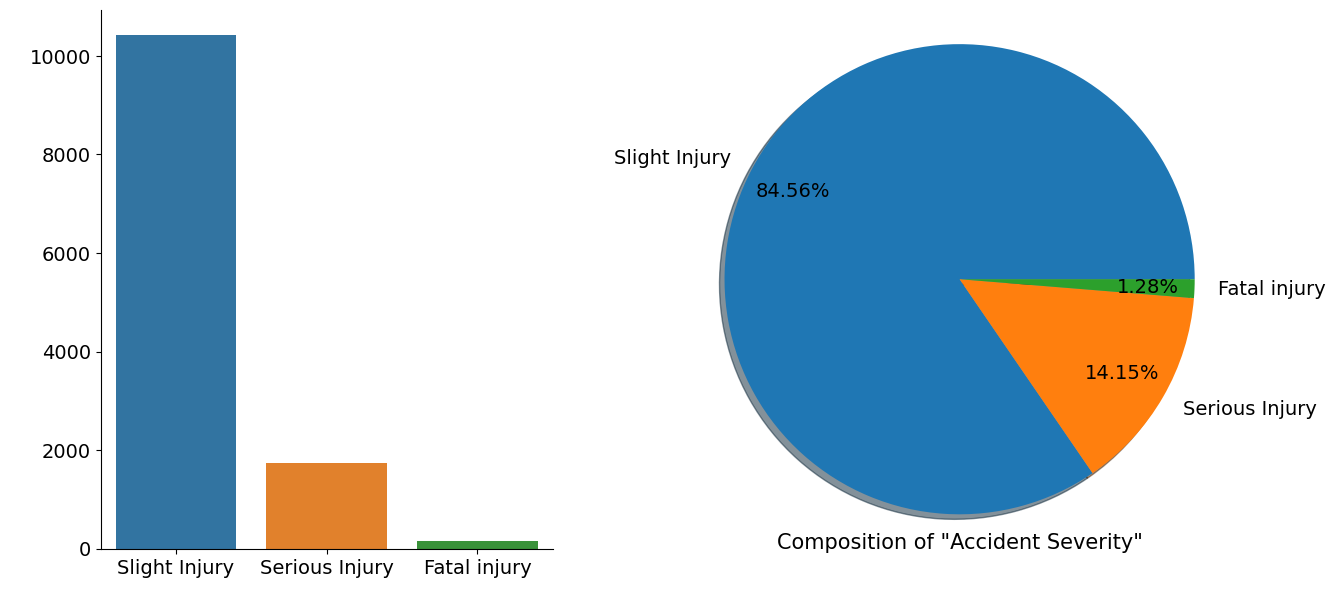

In [17]:
# checking the target
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=raw_df["accident_severity"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
# pieplot
ax2 = plt.subplot(1,2,2)
plt.pie(raw_df["accident_severity"].value_counts(),
        labels=list(raw_df["accident_severity"].unique()),
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize':14}
       )
ax2.set_xlabel(" ")
plt.xlabel('Composition of "Accident Severity"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [18]:
fig = px.treemap(raw_df, path=['accident_cause'], width=800, height=400)
fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25))
# fig.show()

py.init_notebook_mode(connected=True)
py.iplot(fig,filename= "treemap")

In [19]:
# converting 'time' to datetime
raw_df['time'] = pd.to_datetime(raw_df['time'])

# date (day-month-year) time
raw_df["time"].dt.hour

# extracting hour and minute from timestamp
raw_df['hour'] = raw_df['time'].dt.hour
raw_df['minute'] = raw_df['time'].dt.minute
raw_df.drop('time', axis=1, inplace=True)

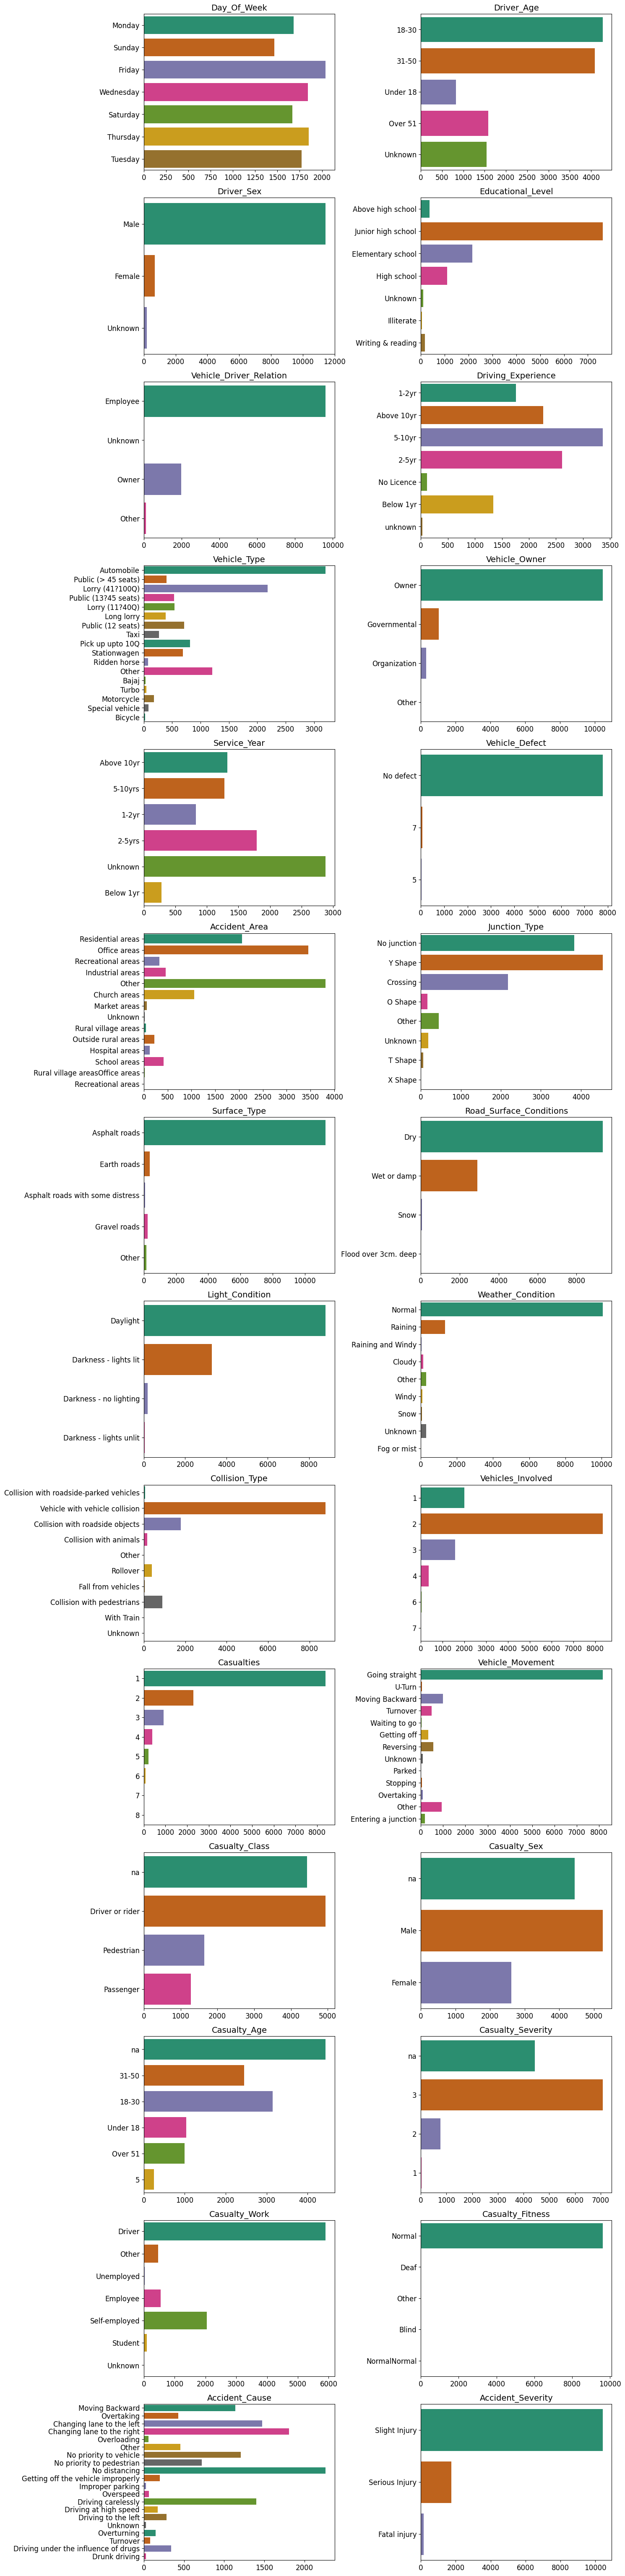

In [20]:
plt.figure(figsize=(15,70))
plotnumber = 1

for col in raw_df.drop(['hour', 'minute', 'lanes', 'road_allignment', 'pedestrian_movement'], axis=1):
    if plotnumber <= raw_df.shape[1]:
        ax1 = plt.subplot(16,2,plotnumber)
        sns.countplot(data=raw_df, y=col, palette='Dark2')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(col.title(), fontsize=14)
        plt.xlabel('')
        plt.ylabel('')
    plotnumber +=1
plt.tight_layout()

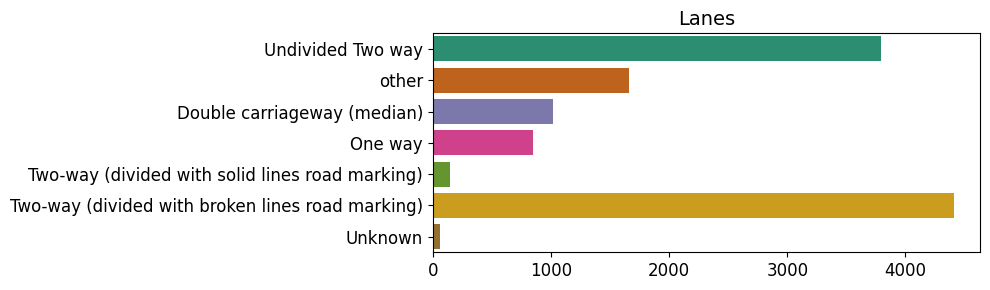

In [21]:
plt.figure(figsize=(10,3))
sns.countplot(data=raw_df, y='lanes', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Lanes', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

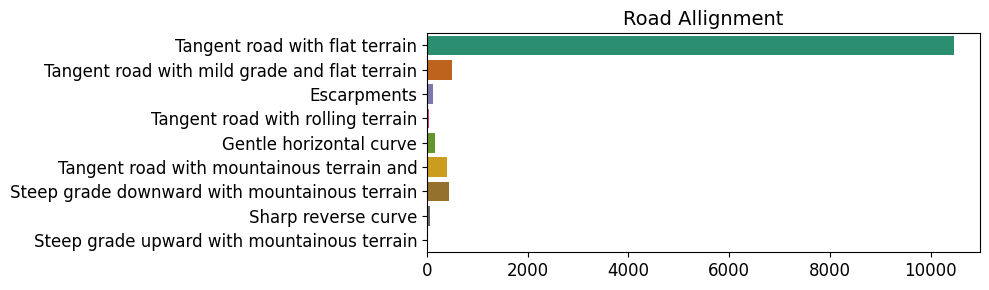

In [22]:
plt.figure(figsize=(10,3))
sns.countplot(data=raw_df, y='road_allignment', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Road Allignment', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

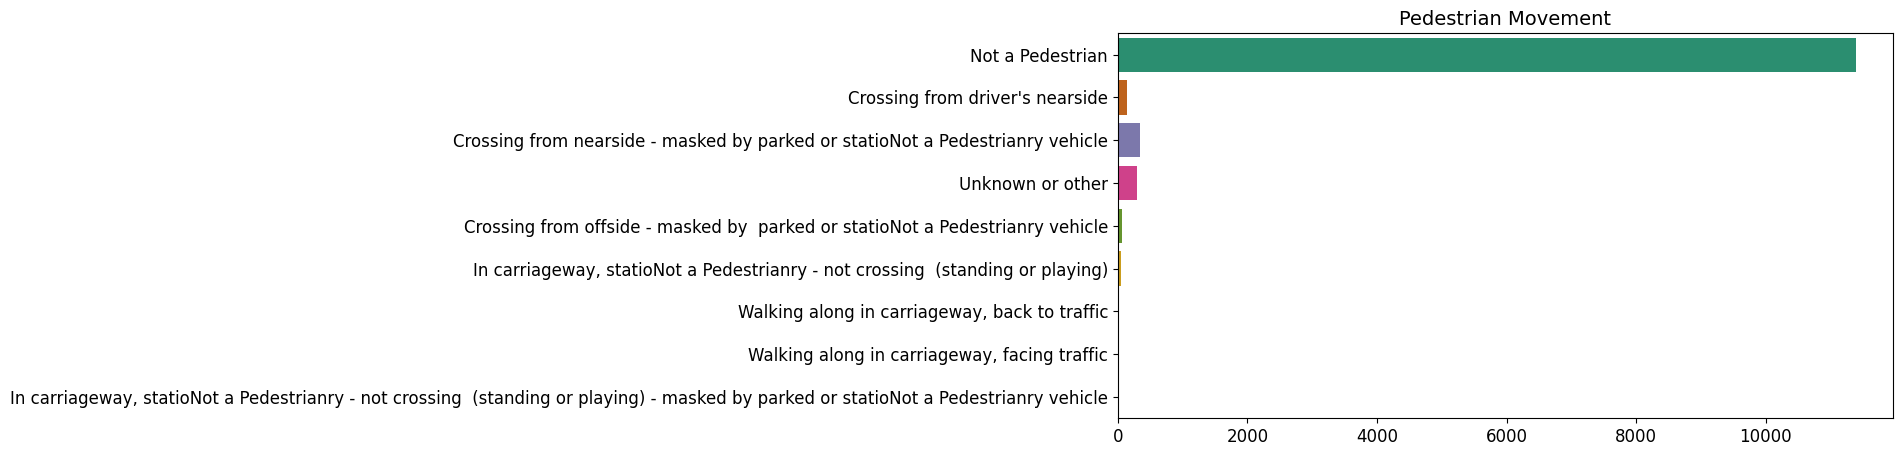

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(data=raw_df, y='pedestrian_movement', palette = 'Dark2')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Pedestrian Movement', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

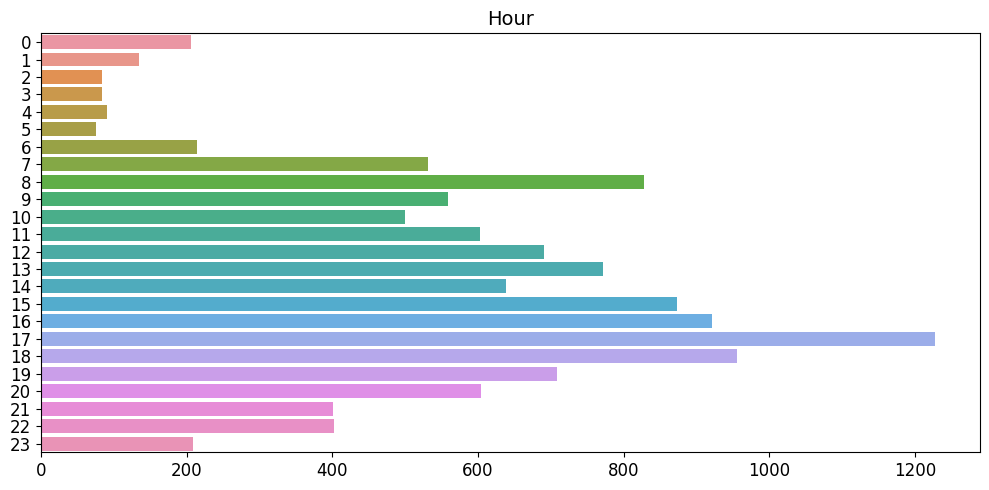

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(data=raw_df, y='hour')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Hour', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

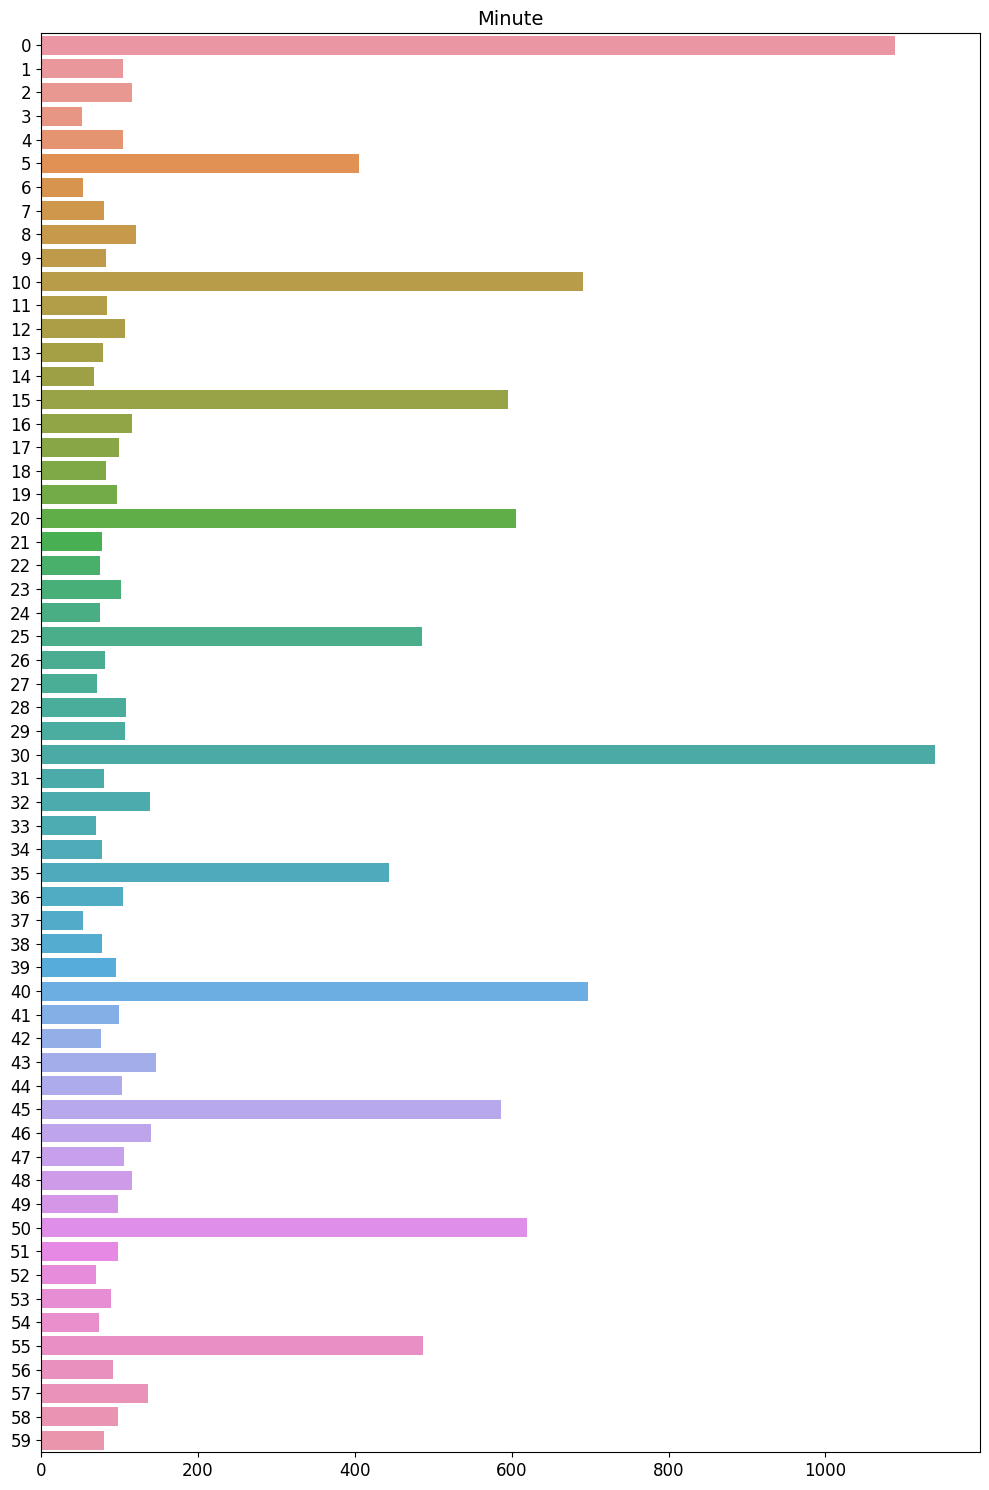

In [25]:
plt.figure(figsize=(10,15))
sns.countplot(data=raw_df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

In [26]:
min = list(range(5,56, 5))
def convert_minutes(x: int):
    for m in min:
        if x % m == x and x > m-5:
            return m
        if x in [56,57,58,59]:
            return 0
        if x in min+[0]:
            return x

In [27]:
raw_df['minute'] = raw_df['minute'].apply(lambda x: convert_minutes(x))

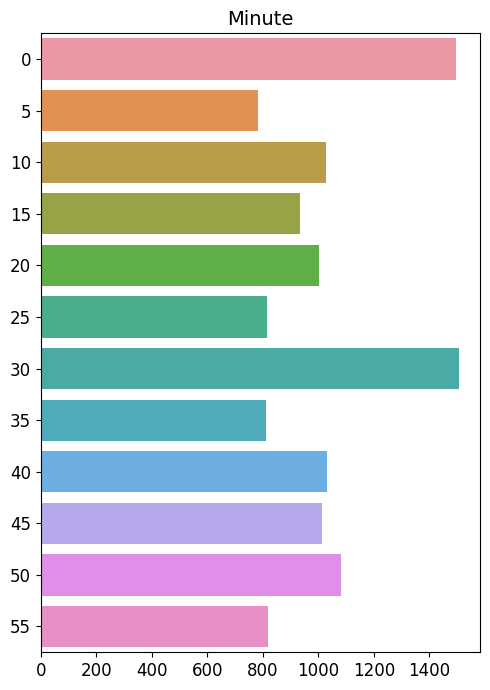

In [28]:
plt.figure(figsize=(5,7))
sns.countplot(data=raw_df, y='minute')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Minute', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

# Hypothesis 1: Which of both genders is actually dangerous in Driving?
Calculating the Conditional Probability; Probability of an Accident Happen When the Driver is a Female and Repeating the Calculations when it's Male.
<br>
P(Gender = Male | Severity = 2) P(Gender = Female | Severity = 2)

In [29]:
hypothesis_df = raw_df.copy(deep=True)
((hypothesis_df.groupby(['driver_sex']).size() / hypothesis_df["driver_sex"].count()) * 100).add_prefix('Accidents(in %) Caused by ')

driver_sex
Accidents(in %) Caused by Female      5.691783
Accidents(in %) Caused by Male       92.862943
Accidents(in %) Caused by Unknown     1.445274
dtype: float64

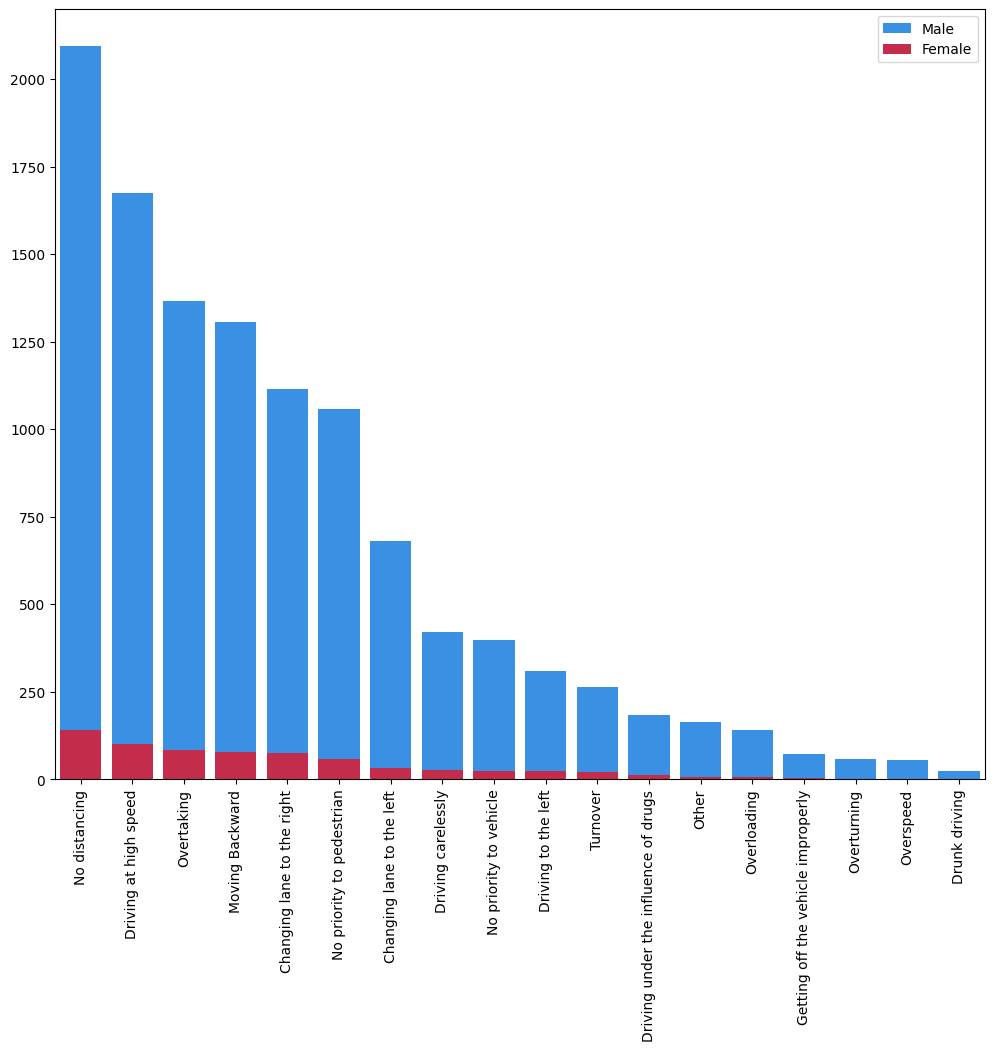

In [30]:
plt.figure(figsize=(12,10))
male_df = hypothesis_df.loc[hypothesis_df.driver_sex == 'Male']
female_df = hypothesis_df.loc[hypothesis_df.driver_sex == 'Female']
sns.barplot(data=male_df,x = male_df.accident_cause.unique(),y = male_df.accident_cause.value_counts().values,color='dodgerblue', label="Male")
sns.barplot(data=female_df,x = female_df.accident_cause.unique(),y = female_df.accident_cause.value_counts().values,color='crimson', label="Female")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [31]:
ff = pd.crosstab(index=hypothesis_df['driver_sex'].loc[hypothesis_df['driver_sex'] !="Unknown"], columns=raw_df['accident_severity']
                 , margins=True)
ff

accident_severity  Fatal injury  Serious Injury  Slight Injury    All
driver_sex                                                           
Female                        5             104            592    701
Male                        152            1621           9664  11437
All                         157            1725          10256  12138

In [32]:
print("P(Gender = Female | Severity = Fatal) = " + str((ff.iloc[0,0])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Fatal) = " + str((ff.iloc[1,0])/(ff.iloc[1,3]*1.0)*100) + '%\n')

print("P(Gender = Female | Severity = Serious Injury) = " + str((ff.iloc[0,1])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Serious Injury) = " + str((ff.iloc[1,1])/(ff.iloc[1,3]*1.0)*100) + '%\n')

print("P(Gender = Female | Severity = Slight Injury) = " + str((ff.iloc[0,2])/(ff.iloc[0,3]*1.0)*100) + '%')
print("P(Gender = Male | Severity = Slight Injury) = " + str((ff.iloc[1,2])/(ff.iloc[1,3]*1.0)*100) + '%')

P(Gender = Female | Severity = Fatal) = 0.7132667617689016%
P(Gender = Male | Severity = Fatal) = 1.3290198478622017%

P(Gender = Female | Severity = Serious Injury) = 14.835948644793154%
P(Gender = Male | Severity = Serious Injury) = 14.173297193319925%

P(Gender = Female | Severity = Slight Injury) = 84.45078459343794%
P(Gender = Male | Severity = Slight Injury) = 84.49768295881788%


# Hypothesis 2: Is Speeding the main Cause for Car Crashes?

In [33]:
ff = pd.crosstab(index=hypothesis_df['accident_cause'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['accident_cause'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity                     Fatal injury  Serious Injury   
accident_cause                                                       
Changing lane to the left                       16             206  \
Changing lane to the right                      23             260   
Driving at high speed                            2              31   
Driving carelessly                              22             209   
Driving to the left                              4              53   
Driving under the influence of drugs             5              46   
Drunk driving                                    0               3   
Getting off the vehicle improperly               3              29   
Improper parking                                 1               2   
Moving Backward                                 26             162   
No distancing                                   20             303   
No priority to pedestrian                        5              95   
No priority to vehicle                          13             149   
Other                                            7              64   
Overloading                                      2              10   
Overspeed                                        1              15   
Overtaking                                       4              75   
Overturning                                      2              23   
Turnover                                         2               6   
Unknown                                          0               2   
All                                            158            1743   

accident_severity                     Slight Injury    All  
accident_cause                                              
Changing lane to the left                      1251   1473  
Changing lane to the right                     1525   1808  
Driving at high speed                           141    174  
Driving carelessly                             1171   1402  
Driving to the left                             227    284  
Driving under the influence of drugs            289    340  
Drunk driving                                    24     27  
Getting off the vehicle improperly              165    197  
Improper parking                                 22     25  
Moving Backward                                 949   1137  
No distancing                                  1940   2263  
No priority to pedestrian                       621    721  
No priority to vehicle                         1045   1207  
Other                                           385    456  
Overloading                                      47     59  
Overspeed                                        45     61  
Overtaking                                      351    430  
Overturning                                     124    149  
Turnover                                         70     78  
Unknown                                          23     25  
All                                           10415  12316

In [34]:
print(f'Injuries(all types due to speeding): {ff.iloc[2,2]}/{ff.iloc[3,3]}')
print(f'In percentage: {(ff.iloc[2,2]/ff.iloc[3,3])*100} %')

Injuries(all types due to speeding): 141/1402
In percentage: 10.057061340941512 %


# Hypothesis 3: Do weekends account for more accidents?

In [35]:
ff = pd.crosstab(index=hypothesis_df['day_of_week'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['day_of_week'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity  Fatal injury  Serious Injury  Slight Injury    All
day_of_week                                                          
Friday                       16             313           1712   2041
Monday                       12             204           1465   1681
Saturday                     37             245           1384   1666
Sunday                       35             190           1242   1467
Thursday                     22             272           1557   1851
Tuesday                      17             257           1496   1770
Wednesday                    19             262           1559   1840
All                         158            1743          10415  12316

In [36]:
print('Accident percentage on weekdays:',round(sum([ff.iloc[i,3] for i in range(0,7) if ff.index[i] not in ['Saturday','Sunday']])/ff.iloc[7,3],2))
print('Accident percentage on weekends:',round(sum([ff.iloc[i,3] for i in range(0,7) if ff.index[i] in ['Saturday','Sunday']])/ff.iloc[7,3],2))

Accident percentage on weekdays: 0.75
Accident percentage on weekends: 0.25


# Hypothesis 4: Are there more dangerous injuries at night than in day?

In [37]:
ff = pd.crosstab(index=hypothesis_df['light_condition'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['light_condition'], columns=hypothesis_df['accident_severity'], margins=True)
ff

accident_severity        Fatal injury  Serious Injury  Slight Injury    All
light_condition                                                            
Darkness - lights lit              66             465           2755   3286
Darkness - lights unlit             0               7             33     40
Darkness - no lighting              5              49            138    192
Daylight                           87            1222           7489   8798
All                               158            1743          10415  12316

In [38]:
sol = 0
for i in [0,1]:
    for j in [0,1,2]:
        sol += ff.iloc[j,i]

r = sol/(sum(ff.iloc[i,3] for i in [0,1,2]))
print('Dangerous injuries at night:',round(r,2),'%')
r = sum(ff.iloc[i,2] for i in [0,1,2])/sum(ff.iloc[i,3] for i in [0,1,2])
print('Slight injuries at night:',round(r,2),'%')

Dangerous injuries at night: 0.17 %
Slight injuries at night: 0.83 %


In [39]:
r = sum(ff.iloc[3,i] for i in [0,1])/ff.iloc[3,3]
print('Dangerous injuries at day:',round(r,2),'%')
r = ff.iloc[3,2]/ff.iloc[3,3]
print('Slight injuries at day:',round(r,2),'%')

Dangerous injuries at day: 0.15 %
Slight injuries at day: 0.85 %


# Hypothesis 5: More accidents under some specific non-normal weather?

In [40]:
ff = pd.crosstab(index=hypothesis_df['weather_condition'], columns=hypothesis_df['accident_severity'], margins=True)
pd.crosstab(index=hypothesis_df['weather_condition'], columns=hypothesis_df['accident_severity'], margins=True)
ff.drop(['Normal','All'],axis=0)

accident_severity  Fatal injury  Serious Injury  Slight Injury   All
weather_condition                                                   
Cloudy                        0               8            117   125
Fog or mist                   0               1              9    10
Other                         0              28            268   296
Raining                      23             158           1150  1331
Raining and Windy             0               2             38    40
Snow                          0               5             56    61
Unknown                       0              51            241   292
Windy                         0              16             82    98

# Preprocessing

In [41]:
import pandas as pd

def drop_null_cols(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """
    Drops columns from a dataframe that have null value count greater than the threshold.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe.
    threshold (int): The maximum allowed null value count for a column.
    
    Returns:
    pandas.DataFrame: The modified dataframe with dropped columns.
    """
    # get the null value count for each column
    null_counts = df.isnull().sum()
    
    # get the column names where null value count is greater than the threshold
    cols_to_drop = null_counts[null_counts > threshold].index.tolist()
    
    # drop the columns and return the modified dataframe
    return df.drop(cols_to_drop, axis=1)


In [42]:
df = drop_null_cols(raw_df, 2000)

In [43]:
df.shape

(12316, 29)

In [44]:
def ordinal_encoder(df: pd.DataFrame, feats: pd.DataFrame.columns) -> pd.DataFrame:
    """
    Perform Ordinal Encoder to the dataset

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe to perform the ordinal encoder on.

    feats: pd.DataFrame.columns
        The columns to perform the ordinal encoder on.

    Returns
    -------
    df: pd.DataFrame
        The dataframe with the ordinal encoded columns.
    """
    for feat in feats:
        feat_val = list(np.arange(df[feat].nunique()))
        feat_key = list(df[feat].sort_values().unique())
        feat_dict = dict(zip(feat_key, feat_val))
        df[feat] = df[feat].map(feat_dict)
    return df

In [45]:
df = ordinal_encoder(df, df.columns)
df.head()

day_of_week  driver_age  driver_sex  educational_level   
0            1           0           1                0.0  \
1            1           1           1                4.0   
2            1           0           1                4.0   
3            3           0           1                4.0   
4            3           0           1                4.0   

   vehicle_driver_relation  driving_experience  vehicle_type  vehicle_owner   
0                      0.0                 0.0           0.0            3.0  \
1                      0.0                 3.0          11.0            3.0   
2                      0.0                 0.0           5.0            3.0   
3                      0.0                 2.0          11.0            0.0   
4                      0.0                 1.0           NaN            3.0   

   accident_area  lanes  road_allignment  junction_type  surface_type   
0            9.0    NaN              5.0            1.0           0.0  \
1            6.0    4.0              5.0            1.0           0.0   
2            1.0    6.0              NaN            1.0           0.0   
3            6.0    6.0              6.0            7.0           2.0   
4            4.0    6.0              5.0            7.0           0.0   

   road_surface_conditions  light_condition  weather_condition   
0                        0                3                  2  \
1                        0                3                  2   
2                        0                3                  2   
3                        0                0                  2   
4                        0                0                  2   

   collision_type  vehicles_involved  casualties  vehicle_movement   
0             3.0                  1           1               2.0  \
1             8.0                  1           1               2.0   
2             2.0                  1           1               2.0   
3             8.0                  1           1               2.0   
4             8.0                  1           1               2.0   

   casualty_class  casualty_sex  casualty_age  casualty_severity   
0               3             2             5                  3  \
1               3             2             5                  3   
2               0             1             1                  2   
3               2             0             0                  2   
4               3             2             5                  3   

   pedestrian_movement  accident_cause  accident_severity  hour  minute  
0                    5               9                  2    17       1  
1                    5              16                  2    17       1  
2                    5               0                  1    17       1  
3                    5               1                  2     1       2  
4                    5              16                  2     1       2

In [46]:
def knn_impute(df: pd.DataFrame) -> pd.DataFrame:
    """
    Impute the null values using KNN Imputer.

    Parameters
    ----------
    df: pd.DataFrame
        The dataframe to impute the null values of.

    Returns
    -------
    df: pd.DataFrame
        The dataframe with the imputed null values.
    """
    # Create a KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    # Fit the KNN Imputer
    df_imputed = knn_imputer.fit_transform(df)
    # Return the imputed dataframe
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
    return df_imputed

In [47]:
df = knn_impute(df)

In [48]:
df.head()

day_of_week  driver_age  driver_sex  educational_level   
0          1.0         0.0         1.0                0.0  \
1          1.0         1.0         1.0                4.0   
2          1.0         0.0         1.0                4.0   
3          3.0         0.0         1.0                4.0   
4          3.0         0.0         1.0                4.0   

   vehicle_driver_relation  driving_experience  vehicle_type  vehicle_owner   
0                      0.0                 0.0           0.0            3.0  \
1                      0.0                 3.0          11.0            3.0   
2                      0.0                 0.0           5.0            3.0   
3                      0.0                 2.0          11.0            0.0   
4                      0.0                 1.0           7.4            3.0   

   accident_area  lanes  road_allignment  junction_type  surface_type   
0            9.0    3.6              5.0            1.0           0.0  \
1            6.0    4.0              5.0            1.0           0.0   
2            1.0    6.0              5.4            1.0           0.0   
3            6.0    6.0              6.0            7.0           2.0   
4            4.0    6.0              5.0            7.0           0.0   

   road_surface_conditions  light_condition  weather_condition   
0                      0.0              3.0                2.0  \
1                      0.0              3.0                2.0   
2                      0.0              3.0                2.0   
3                      0.0              0.0                2.0   
4                      0.0              0.0                2.0   

   collision_type  vehicles_involved  casualties  vehicle_movement   
0             3.0                1.0         1.0               2.0  \
1             8.0                1.0         1.0               2.0   
2             2.0                1.0         1.0               2.0   
3             8.0                1.0         1.0               2.0   
4             8.0                1.0         1.0               2.0   

   casualty_class  casualty_sex  casualty_age  casualty_severity   
0             3.0           2.0           5.0                3.0  \
1             3.0           2.0           5.0                3.0   
2             0.0           1.0           1.0                2.0   
3             2.0           0.0           0.0                2.0   
4             3.0           2.0           5.0                3.0   

   pedestrian_movement  accident_cause  accident_severity  hour  minute  
0                  5.0             9.0                2.0  17.0     1.0  
1                  5.0            16.0                2.0  17.0     1.0  
2                  5.0             0.0                1.0  17.0     1.0  
3                  5.0             1.0                2.0   1.0     2.0  
4                  5.0            16.0                2.0   1.0     2.0

<Axes: >

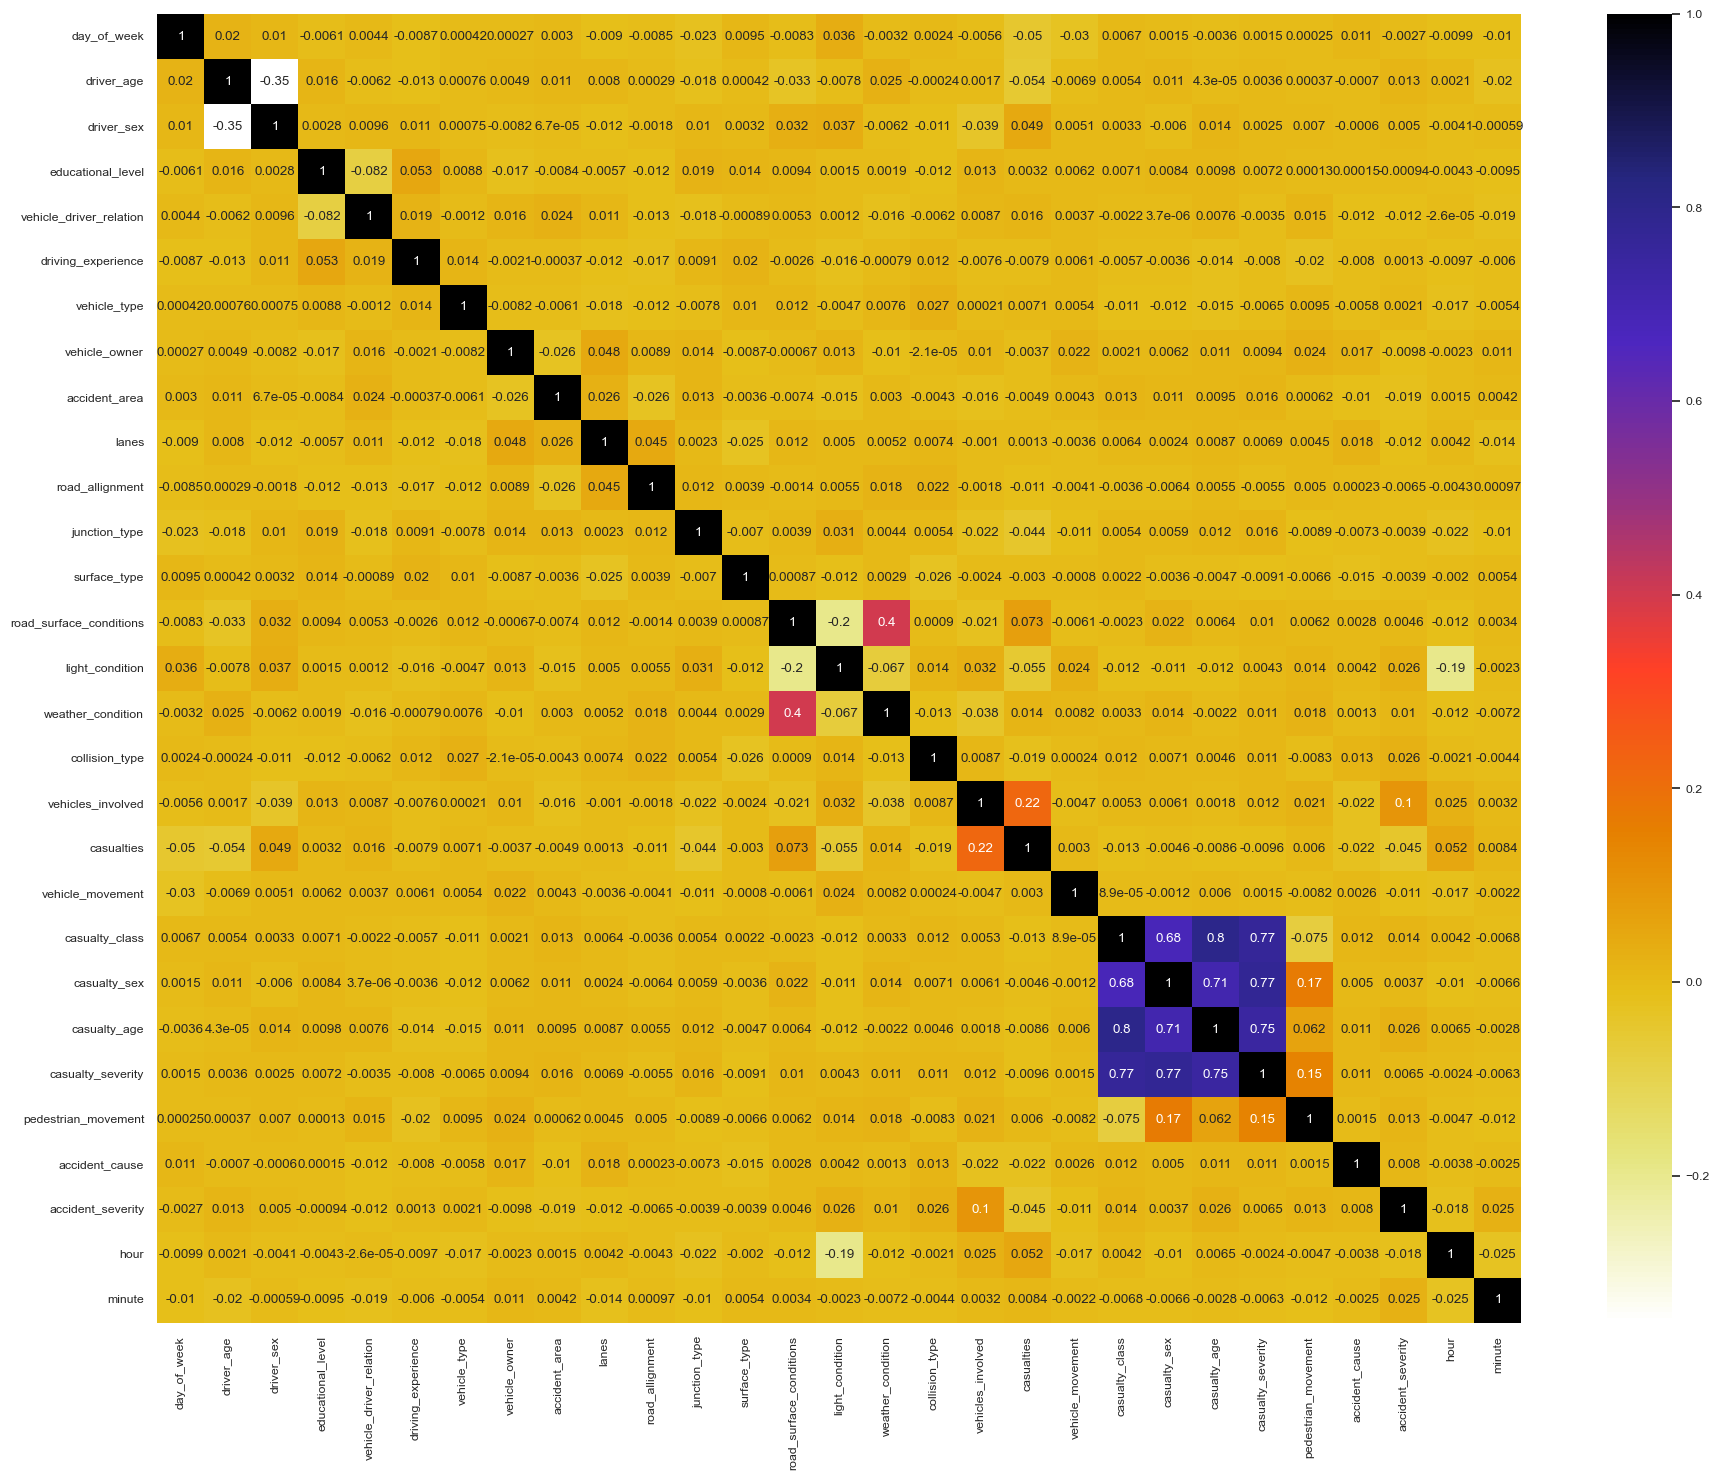

In [49]:
plt.figure(figsize=(22,17))
sns.set(font_scale=0.8)
sns.heatmap(df.corr(), annot=True, cmap=plt.cm.CMRmap_r)

# Resampling

In [50]:
def smote_upsample(X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    """
    Upsample the minority class using SMOTE.

    Parameters
    ----------
    X_train: numpy.ndarray
        The feature matrix of the training data.

    y_train: numpy.ndarray
        The target vector of the training data.

    Returns
    -------
    tuple of numpy.ndarray
        The upsampled feature matrix and target vector.
    """

    # Print class distribution before upsampling
    print("=============================")
    counter = Counter(y_train)
    for k,v in counter.items():
        per = 100*v/len(y_train)
        print(f"Class= {k}, n={v} ({per:.2f}%)")

    # Perform SMOTE upsampling
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Print class distribution after upsampling
    print("=============================")
    counter = Counter(y_train)
    for k,v in counter.items():
        per = 100*v/len(y_train)
        print(f"Class= {k}, n={v} ({per:.2f}%)")
    print("=============================")

    print("Upsampled data shape: ", X_train.shape, y_train.shape)

    return X_train, y_train

In [51]:
X = df.drop('accident_severity', axis=1)
y = df['accident_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8621, 28) (3695, 28) (8621,) (3695,)


In [52]:
X_train, y_train = smote_upsample(X_train, y_train)

Class= 2.0, n=7324 (84.96%)
Class= 1.0, n=1191 (13.82%)
Class= 0.0, n=106 (1.23%)
Class= 2.0, n=7324 (33.33%)
Class= 1.0, n=7324 (33.33%)
Class= 0.0, n=7324 (33.33%)
Upsampled data shape:  (21972, 28) (21972,)


# Baseline Modelling

In [53]:
def train_and_evaluate_multiple_models(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, models: list[str], metrics: list[str] = ["accuracy"], average: str = "weighted") -> dict[str, dict[str, float]]:
    """
    Train and evaluate multiple classifiers on the given data.

    Parameters
    ----------
    X_train: pd.DataFrame
        The features for the training data.

    y_train: pd.Series
        The target variable for the training data.

    X_test: pd.DataFrame
        The features for the testing data.

    y_test: pd.Series
        The target variable for the testing data.

    models: list[str]
        A list of classifiers to use, can include 'XGBoost', 'Random Forest', 'Extra Trees', 'Adaboost'.
        
    metrics: list[str], optional, default: ["accuracy"]
        The evaluation metrics to use, can include 'accuracy', 'precision', 'f1', and 'recall'.

    average: str, optional, default: "weighted"
        The averaging method for multiclass targets, one of [None, 'micro', 'macro', 'weighted'].
    
    Returns
    -------
    results: dict[str, dict[str, float]]
        A dictionary with the model names as keys, then a nested dictionary with metrics as key and the value of the metric as the value.
    """
    model_dict = {
        "XGBoost": XGBClassifier,
        "Random Forest": RandomForestClassifier,
        "Extra Trees": ExtraTreesClassifier,
        "Adaboost": AdaBoostClassifier
    }
    
    metric_dict = {
        "accuracy": accuracy_score,
        "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average=average),
        "f1": lambda y_true, y_pred: f1_score(y_true, y_pred, average=average),
        "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average=average)
    }
    
    num_classes = len(y_train.unique())

    results = {}
    for model in models:
        if model not in model_dict:
            raise ValueError(f"Invalid model name: {model}. Must be one of: {list(model_dict.keys())}")

        if model == "XGBoost":
            classifier = model_dict[model](objective='multi:softprob', num_class=num_classes)
        else:
            classifier = model_dict[model]()
        
        logging.info(f"Training {model}...")
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        logging.info(f"Predicting with {model}...")
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        predict_time = time.time() - start_time
        
        model_results = {
            "train_time": train_time,
            "predict_time": predict_time
        }
        for metric in metrics:
            if metric not in metric_dict:
                raise ValueError(f"Invalid metric name: {metric}. Must be one of: {list(metric_dict.keys())}")
            model_results[metric] = metric_dict[metric](y_test, y_pred)
        
        results[model] = model_results
        logging.info(f"{model} evaluation complete.\n")

    return results

In [54]:
models = ["XGBoost", "Random Forest", "Extra Trees", "Adaboost"]
metrics = ["accuracy", "precision", "f1", "recall"]

results = train_and_evaluate_multiple_models(X_train, y_train, X_test, y_test, models, metrics)

print(results)

2023-04-18 19:41:52,125 - INFO - Training XGBoost...
2023-04-18 19:41:56,894 - INFO - Predicting with XGBoost...
2023-04-18 19:41:56,907 - INFO - XGBoost evaluation complete.

2023-04-18 19:41:56,908 - INFO - Training Random Forest...
2023-04-18 19:42:00,707 - INFO - Predicting with Random Forest...
2023-04-18 19:42:00,773 - INFO - Random Forest evaluation complete.

2023-04-18 19:42:00,775 - INFO - Training Extra Trees...
2023-04-18 19:42:02,389 - INFO - Predicting with Extra Trees...
2023-04-18 19:42:02,462 - INFO - Extra Trees evaluation complete.

2023-04-18 19:42:02,466 - INFO - Training Adaboost...
2023-04-18 19:42:03,850 - INFO - Predicting with Adaboost...
2023-04-18 19:42:03,870 - INFO - Adaboost evaluation complete.



{'XGBoost': {'train_time': 4.764123201370239, 'predict_time': 0.0070912837982177734, 'accuracy': 0.8381596752368065, 'precision': 0.7938445816183112, 'f1': 0.7885316215455829, 'recall': 0.8381596752368065}, 'Random Forest': {'train_time': 3.798558235168457, 'predict_time': 0.059018850326538086, 'accuracy': 0.8397834912043302, 'precision': 0.8051187256887345, 'f1': 0.7797932094866602, 'recall': 0.8397834912043302}, 'Extra Trees': {'train_time': 1.6139252185821533, 'predict_time': 0.06778907775878906, 'accuracy': 0.8389715832205683, 'precision': 0.8039552330659377, 'f1': 0.7736959989699742, 'recall': 0.8389715832205683}, 'Adaboost': {'train_time': 1.3841090202331543, 'predict_time': 0.015373945236206055, 'accuracy': 0.7234100135317997, 'precision': 0.7462361368081446, 'f1': 0.7343147535242769, 'recall': 0.7234100135317997}}


In [55]:
def model_performance_report(model, y_test: pd.Series, y_pred: pd.Series) -> None:
    """
    Visualize model performance using a confusion matrix and metrics.

    Parameters
    ----------
    model: estimator instance
        The classifier model instance.
        
    y_test: pd.Series
        The true target variable for the testing data.

    y_pred: pd.Series
        The predicted target variable for the testing data.
    """
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z=conf_matrix,
                        x=["0 (pred)", "1 (pred)", "2 (pred)"],
                        y=["0 (true)", "1 (true)", "2 (true)"],
                        xgap=2, ygap=2,
                        colorscale='Viridis', showscale=False)

    # Calculate metrics
    Accuracy = accuracy_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred, average='weighted')
    Recall = recall_score(y_test, y_pred, average='weighted')
    F1_score = f1_score(y_test, y_pred, average='weighted')

    show_metrics = pd.DataFrame(data=[[Accuracy, Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x=show_metrics[0].values,
                    y=['Accuracy', 'Precision', 'Recall', 'F1_score'],
                    text=np.round_(show_metrics[0].values, 4),
                    textposition='auto',
                    orientation='h', opacity=0.8,
                    marker=dict(
                        color=colors,
                        line=dict(color='#000000', width=1.5)))

    # Create subplots
    fig = sp.make_subplots(rows=2, cols=1, print_grid=False,
                           subplot_titles=('Confusion Matrix',
                                           'Metrics',
                                           ))

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)

    fig.update_layout(showlegend=False,
                      title='<b>Model performance report</b><br>' + str(model),
                      autosize=True, height=800, width=800,
                      plot_bgcolor='rgba(240,240,240, 0.95)',
                      paper_bgcolor='rgba(240,240,240, 0.95)',
                      )
    fig.layout.titlefont.size = 14

    pio.show(fig, filename='model-performance')

In [56]:
# Train a model and get predictions
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Call the model_performance_report function
model_performance_report(model, y_test, y_pred)

# Hyperparameter Tuning

In [57]:
def tune_hyperparameters(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    models: list[str] = ["XGBoost", "Random Forest", "Extra Trees", "Adaboost"],
    scoring: str = "accuracy",
    cv_type: str = "KFold",
    n_splits: int = 5,
    tuning_type: str = "GridSearchCV",
    xgb_params: dict = None,
    rf_params: dict = None,
    et_params: dict = None,
    ab_params: dict = None,
) -> dict[str, dict[str, float]]:
    """
    Automatically perform hyperparameter tuning for the selected models.

    Parameters
    ----------
    X_train: pd.DataFrame
        The features for the training data.

    y_train: pd.Series
        The target variable for the training data.

    models: list[str], optional, default: ["XGBoost", "Random Forest", "Extra Trees", "Adaboost"]
        A list of classifiers to use, can include 'XGBoost', 'Random Forest', 'Extra Trees', 'Adaboost'.

    scoring: str, optional, default: "accuracy"
        The scoring metric to be used for hyperparameter tuning.

    cv_type: str, optional, default: "KFold"
        The type of cross-validation to use, one of ["KFold", "StratifiedKFold"].

    tuning_type: str, optional, default: "GridSearchCV"
        The type of hyperparameter tuning to use, one of ["GridSearchCV", "RandomizedSearchCV"].

    xgb_params: dict, optional
        A dictionary of hyperparameters for the XGBoost model.

    rf_params: dict, optional
        A dictionary of hyperparameters for the Random Forest model.

    et_params: dict, optional
        A dictionary of hyperparameters for the Extra Trees model.

    ab_params: dict, optional
        A dictionary of hyperparameters for the Adaboost model.

    Returns
    -------
    results: dict[str, dict[str, float]]
        A dictionary with the model names as keys, then a nested dictionary with the keys 'best_params_' and 'best_score_' and their corresponding values as the values.
    """
    model_dict = {
        "XGBoost": XGBClassifier,
        "Random Forest": RandomForestClassifier,
        "Extra Trees": ExtraTreesClassifier,
        "Adaboost": AdaBoostClassifier,
    }

    param_dict = {
        "XGBoost": xgb_params,
        "Random Forest": rf_params,
        "Extra Trees": et_params,
        "Adaboost": ab_params,
    }

    if cv_type == "KFold":
        cv = KFold(n_splits=n_splits)
    elif cv_type == "StratifiedKFold":
        cv = StratifiedKFold(n_splits=n_splits)
    else:
        raise ValueError(f"Invalid cv_type: {cv_type}. Must be one of: ['KFold', 'StratifiedKFold']")

    if tuning_type == "GridSearchCV":
        tuning_function = GridSearchCV
    elif tuning_type == "RandomizedSearchCV":
        tuning_function = RandomizedSearchCV
    else:
        raise ValueError(f"Invalid tuning_type: {tuning_type}. Must be one of: ['GridSearchCV', 'RandomizedSearchCV']")

    results = {}
    for model in models:
        if model not in model_dict:
            raise ValueError(f"Invalid model name: {model}. Must be one of: {list(model_dict.keys())}")

        classifier = model_dict[model]()
        params = param_dict[model]

        if params is None:
            raise ValueError(f"Hyperparameters for {model} are not provided. Please provide a dictionary of hyperparameters for the model.")

        tuner = tuning_function(classifier, params, scoring=scoring, cv=cv)

        total_candidates = len(list(ParameterGrid(params)))
        total_fits = n_splits * total_candidates
        logging.info(f"Fitting {n_splits} folds for each of {total_candidates} candidates, totalling {total_fits} fits")

        logging.info(f"Tuning hyperparameters for {model}...")
        start_time = time.time()
        tuner.fit(X_train, y_train)
        tuning_time = time.time() - start_time

        model_results = {
            "best_params_": tuner.best_params_,
            "best_score_": tuner.best_score_,
            "tuning_time": tuning_time
        }

        results[model] = model_results
        logging.info(f"Hyperparameter tuning for {model} complete.\n")

    return results

In [95]:
ada_params = {
    'n_estimators': [10, 50, 100, 200, 400],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}


# Call the tune_hyperparameters function
results = tune_hyperparameters(
    X_train=X_train,
    y_train=y_train,
    models=["Adaboost"],
    scoring="f1_weighted",
    cv_type="KFold",
    tuning_type="GridSearchCV",
    xgb_params=None,
    rf_params=None,
    et_params=None,
    ab_params=ada_params,
)

2023-04-18 20:46:14,691 - INFO - Fitting 5 folds for each of 50 candidates, totalling 250 fits
2023-04-18 20:46:14,691 - INFO - Fitting 5 folds for each of 50 candidates, totalling 250 fits
2023-04-18 20:46:14,691 - INFO - Fitting 5 folds for each of 50 candidates, totalling 250 fits
2023-04-18 20:46:14,691 - INFO - Fitting 5 folds for each of 50 candidates, totalling 250 fits
2023-04-18 20:46:14,691 - INFO - Fitting 5 folds for each of 50 candidates, totalling 250 fits
2023-04-18 20:46:14,697 - INFO - Tuning hyperparameters for Adaboost...
2023-04-18 20:46:14,697 - INFO - Tuning hyperparameters for Adaboost...
2023-04-18 20:46:14,697 - INFO - Tuning hyperparameters for Adaboost...
2023-04-18 20:46:14,697 - INFO - Tuning hyperparameters for Adaboost...
2023-04-18 20:46:14,697 - INFO - Tuning hyperparameters for Adaboost...
2023-04-18 21:00:03,108 - INFO - Hyperparameter tuning for Adaboost complete.

2023-04-18 21:00:03,108 - INFO - Hyperparameter tuning for Adaboost complete.

2023-04

In [96]:
print(results)

{'Adaboost': {'best_params_': {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 400}, 'best_score_': 0.781426021863572, 'tuning_time': 828.4070053100586}}


In [97]:
best_params = results["Adaboost"]["best_params_"]
print(best_params)

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 400}


In [98]:
best_ada = AdaBoostClassifier(**best_params)
best_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=400)

In [99]:
y_pred = best_ada.predict(X_test)
model_performance_report(best_ada, y_test, y_pred)

In [100]:
# Export the model
joblib.dump(best_ada, "../models/best_ada.pkl")

['../models/best_ada.pkl']

# Explaining the Model

In [111]:
def select_and_save_top_n_features(model: BaseEstimator, best_params: dict, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, top_n: int = 10, save_new_dataset: bool = False, save_consolidated_csv: bool = False) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Select and save the top N most important features from a trained model.

    Parameters
    ----------
    model: Any classifier with a 'feature_importances_' attribute
        The trained classifier used to compute feature importances.

    best_params: dict
        A dictionary containing the best parameters for the model.

    X_train: pd.DataFrame
        The training data.

    y_train: pd.Series
        The training labels.

    X_test: pd.DataFrame
        The testing data.

    y_test: pd.Series
        The testing labels.

    top_n: int
        The number of top features to select.

    save_new_dataset: bool, optional, default: False
        Whether to save the new dataset with the top features.

    save_consolidated_csv: bool, optional, default: False
        Whether to save a consolidated CSV dataset containing both training and testing data.

    Returns
    -------
    new_X_train: pd.DataFrame
        The training data with only the top N features.

    new_X_test: pd.DataFrame
        The testing data with only the top N features.
    """
    # Train the model with the best parameters
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Calculate feature importances and create a DataFrame
    importance = model.feature_importances_
    feature_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": importance}
    ).sort_values("importance", ascending=False)

    # Plot the top N feature importances
    fig = px.bar(feature_importance.head(top_n), x='feature', y='importance', title=f'Top {top_n} Feature Importances')
    fig.show()

    top_features = feature_importance["feature"].head(top_n).tolist()
    new_X_train = X_train[top_features]
    new_X_test = X_test[top_features]

    if save_new_dataset:
        new_X_train.to_csv(os.path.join(DATA_PATH, "X_train_top_n_features.csv"), index=False)
        y_train.to_csv(os.path.join(DATA_PATH, "y_train.csv"), index=False)
        new_X_test.to_csv(os.path.join(DATA_PATH, "X_test_top_n_features.csv"), index=False)
        y_test.to_csv(os.path.join(DATA_PATH, "y_test.csv"), index=False)
        
    if save_consolidated_csv:
        new_train_data = new_X_train.copy()
        new_train_data["label"] = y_train
        new_test_data = new_X_test.copy()
        new_test_data["label"] = y_test
        consolidated_data = pd.concat([new_train_data, new_test_data], axis=0)
        consolidated_data.to_csv(os.path.join(DATA_PATH, "consolidated_top_n_features.csv"), index=False)

    return new_X_train, new_X_test

In [112]:
model = AdaBoostClassifier(**best_params)
model.fit(X_train, y_train)

new_X_train, new_X_test = select_and_save_top_n_features(
    model=model,
    best_params=best_params,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    top_n=10,
    save_new_dataset=True,
    save_consolidated_csv=True,
)

In [116]:
model = joblib.load(os.path.join(MODELS_PATH, "best_ada.pkl"))

In [119]:
df = pd.read_csv(os.path.join(DATA_PATH, "consolidated_top_n_features.csv"))
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_performance_report(model, y_test, y_pred)

In [124]:
background_data = shap.sample(X_train, 50)  # Reduce the number of samples
explainer = shap.TreeExplainer(model, background_data)

In [125]:
subset_X_train = shap.sample(X_train, 100)
subset_X_test = shap.sample(X_test, 100)

shap_values_train = explainer.shap_values(subset_X_train)
shap_values_test = explainer.shap_values(subset_X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

2023-04-18 21:46:46,876 - INFO - num_full_subsets = 5
2023-04-18 21:46:46,876 - INFO - num_full_subsets = 5
2023-04-18 21:46:46,876 - INFO - num_full_subsets = 5
2023-04-18 21:46:46,876 - INFO - num_full_subsets = 5
2023-04-18 21:46:46,876 - INFO - num_full_subsets = 5
2023-04-18 21:46:48,273 - INFO - phi = [ 6.47612811e-04 -3.52287148e-04 -2.57297154e-04  2.92300154e-04
 -6.58200319e-04  6.63075374e-04  3.99232484e-04  2.61670107e-04
  1.78367178e-04  3.72507656e-06]
2023-04-18 21:46:48,273 - INFO - phi = [ 6.47612811e-04 -3.52287148e-04 -2.57297154e-04  2.92300154e-04
 -6.58200319e-04  6.63075374e-04  3.99232484e-04  2.61670107e-04
  1.78367178e-04  3.72507656e-06]
2023-04-18 21:46:48,273 - INFO - phi = [ 6.47612811e-04 -3.52287148e-04 -2.57297154e-04  2.92300154e-04
 -6.58200319e-04  6.63075374e-04  3.99232484e-04  2.61670107e-04
  1.78367178e-04  3.72507656e-06]
2023-04-18 21:46:48,273 - INFO - phi = [ 6.47612811e-04 -3.52287148e-04 -2.57297154e-04  2.92300154e-04
 -6.58200319e-04 

  0%|          | 0/100 [00:00<?, ?it/s]

2023-04-18 21:49:24,972 - INFO - num_full_subsets = 5
2023-04-18 21:49:24,972 - INFO - num_full_subsets = 5
2023-04-18 21:49:24,972 - INFO - num_full_subsets = 5
2023-04-18 21:49:24,972 - INFO - num_full_subsets = 5
2023-04-18 21:49:24,972 - INFO - num_full_subsets = 5
2023-04-18 21:49:26,342 - INFO - phi = [-2.11176752e-04 -6.87111046e-04 -2.56942030e-04 -1.77717126e-04
 -6.56651566e-04 -2.65409697e-04 -7.23148083e-05 -4.38340201e-04
 -3.22642434e-05  3.36502544e-06]
2023-04-18 21:49:26,342 - INFO - phi = [-2.11176752e-04 -6.87111046e-04 -2.56942030e-04 -1.77717126e-04
 -6.56651566e-04 -2.65409697e-04 -7.23148083e-05 -4.38340201e-04
 -3.22642434e-05  3.36502544e-06]
2023-04-18 21:49:26,342 - INFO - phi = [-2.11176752e-04 -6.87111046e-04 -2.56942030e-04 -1.77717126e-04
 -6.56651566e-04 -2.65409697e-04 -7.23148083e-05 -4.38340201e-04
 -3.22642434e-05  3.36502544e-06]
2023-04-18 21:49:26,342 - INFO - phi = [-2.11176752e-04 -6.87111046e-04 -2.56942030e-04 -1.77717126e-04
 -6.56651566e-04 

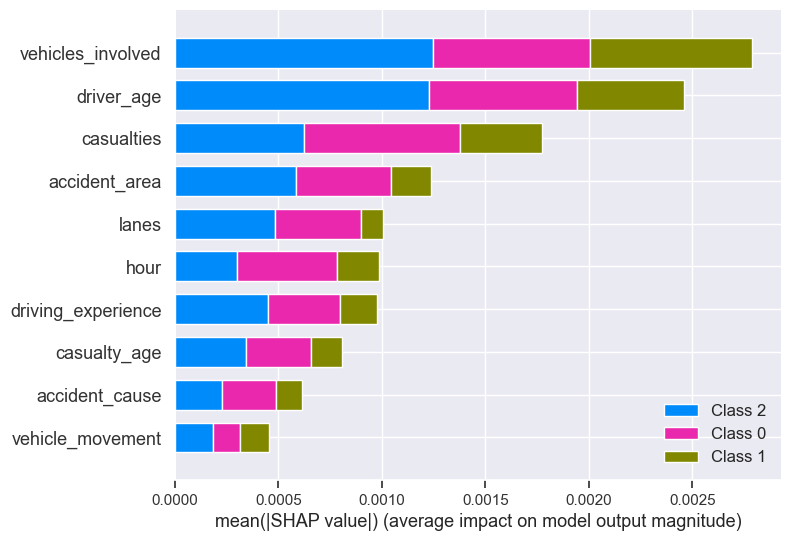

In [126]:
shap.summary_plot(shap_values_train, subset_X_train)

In [127]:
# Plot for a single instance
instance_index = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values_train[1][instance_index],
    subset_X_train.iloc[instance_index],
)

# Plot for a group of instances
shap.force_plot(
    explainer.expected_value[1],
    shap_values_train[1][:10],
    subset_X_train.iloc[:10],
)


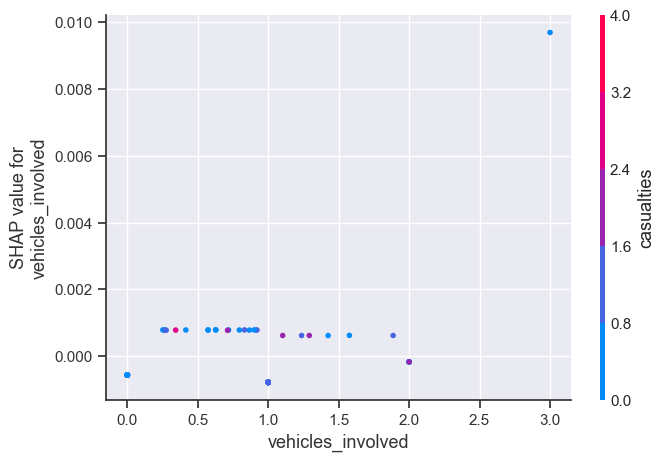

In [129]:
feature_name = "vehicles_involved"
shap.dependence_plot(feature_name, shap_values_train[1], subset_X_train)

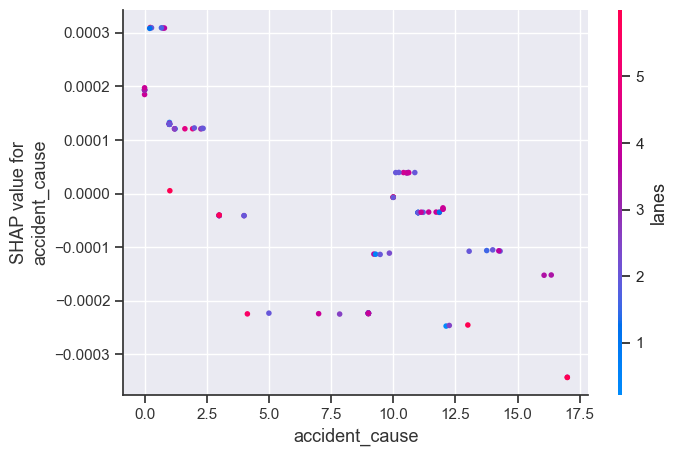

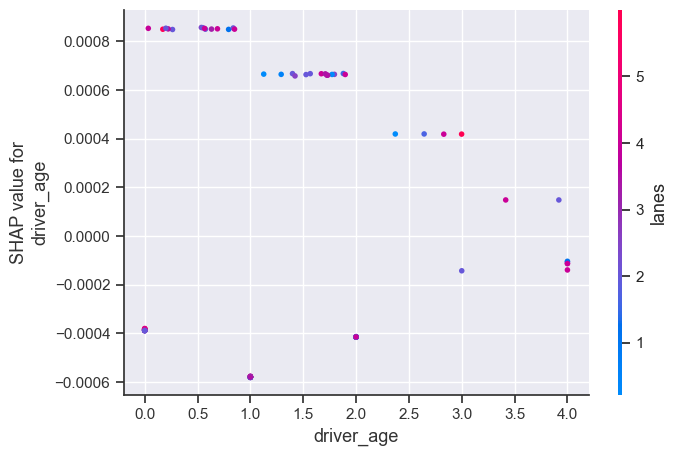

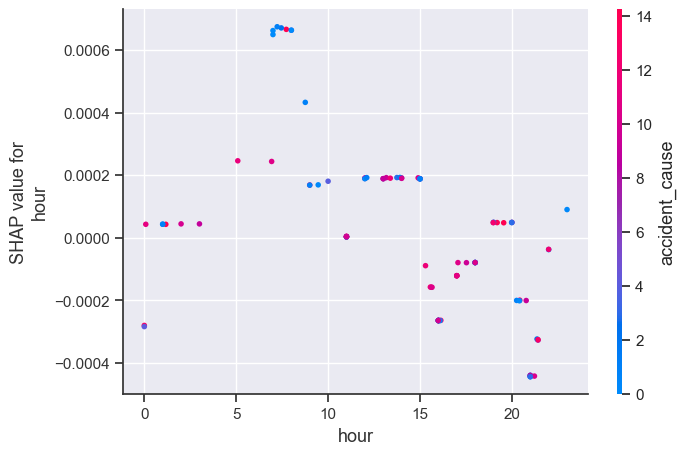

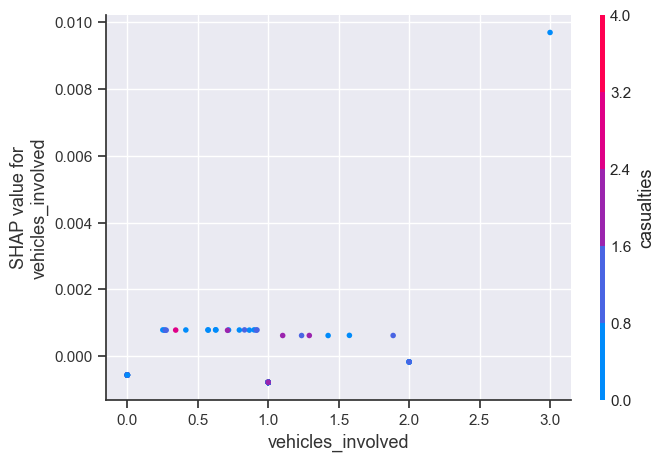

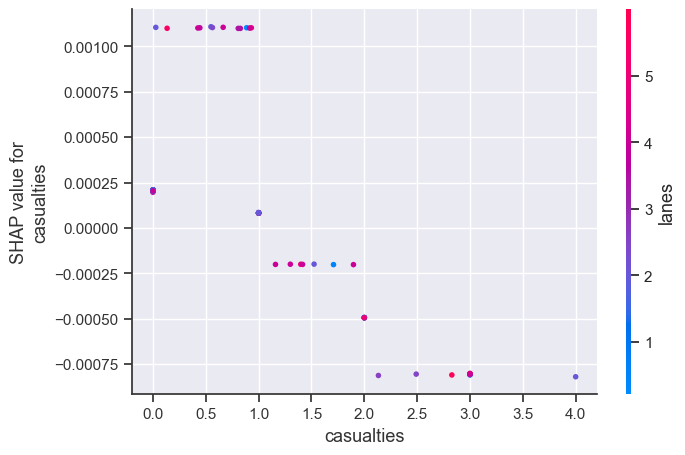

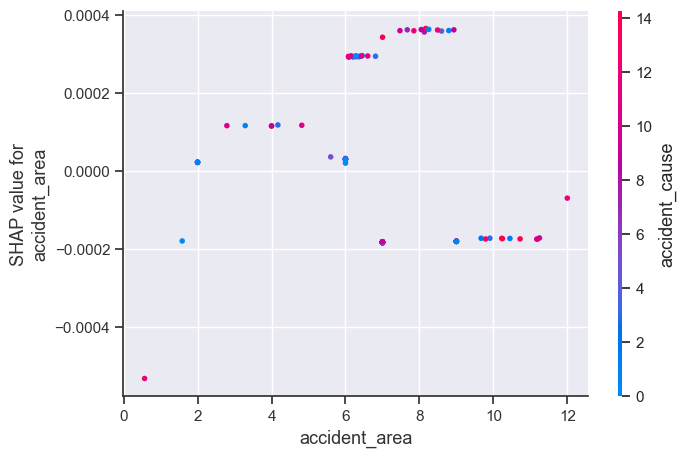

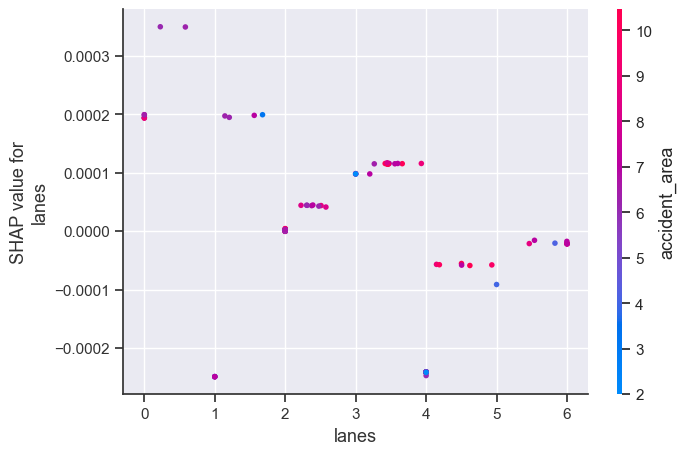

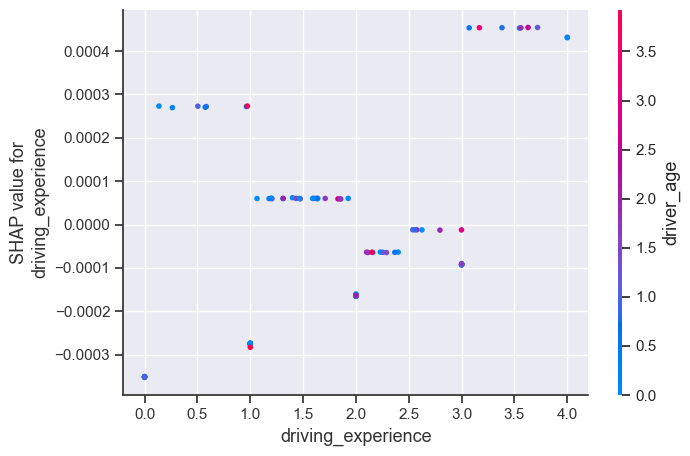

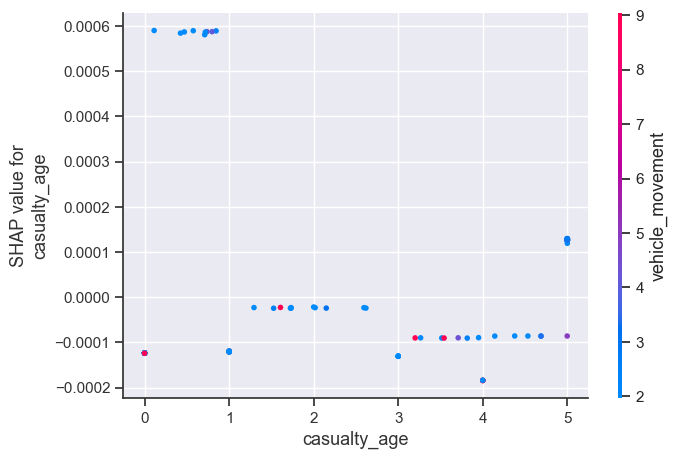

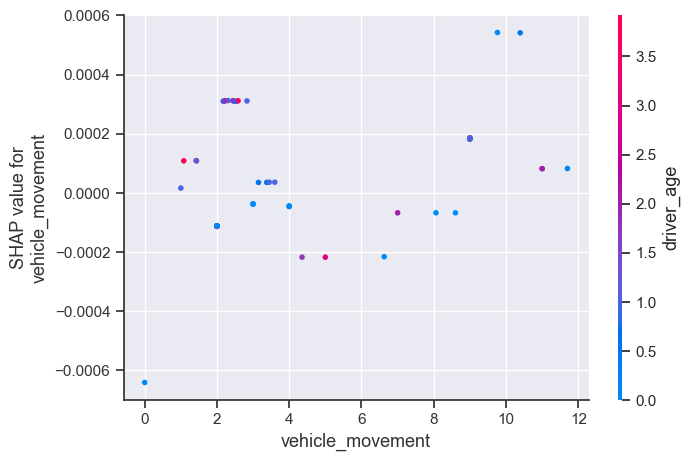

In [131]:
for feature_name in subset_X_train.columns:
    shap.dependence_plot(feature_name, shap_values_train[1], subset_X_train)

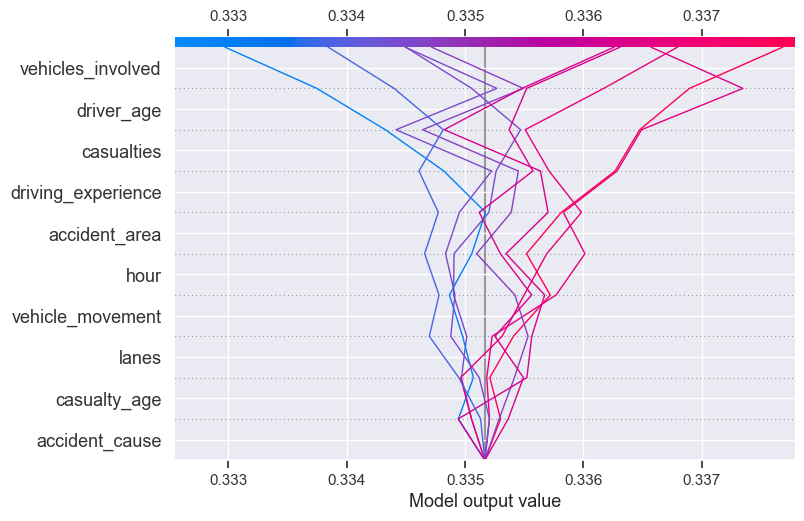

In [132]:
shap.decision_plot(
    explainer.expected_value[1],
    shap_values_train[1][:10],
    subset_X_train.iloc[:10],
)